Congratulations on reaching the assignment stage!

On this assignment you will work with a dataset of real life taxi rides and will prepare a basic prediction model, just like we do at Autofleet.

Instructions will be provided as you progress through this notebook.

Please try to be as detailed and descriptive as possible so that we understand your
thought process.

In [1]:
%matplotlib inline
import pandas as pd
from IPython.display import clear_output
import matplotlib.pyplot as plt 
import seaborn as sns
import scipy
from sklearn.metrics import mean_absolute_error
import numpy as np 

## Load Data

In [2]:
df_rides = pd.read_csv('rides.csv')
df_rides.head()

,RIDE_ID,created_on,created_on_hour,started_on,completed_on,distance_travelled
0,0,2016-06-04 00:10:19,2016-06-04 00:00:00,2016-06-04 00:18:49,2016-06-04 00:27:32,8459.0
1,1,2016-06-04 01:47:39,2016-06-04 01:00:00,2016-06-04 01:50:12,2016-06-04 01:51:49,443.0
2,2,2016-06-04 03:13:07,2016-06-04 03:00:00,2016-06-04 03:16:02,2016-06-04 03:17:57,568.0
3,3,2016-06-04 09:52:35,2016-06-04 09:00:00,2016-06-04 10:05:13,2016-06-04 10:13:38,4051.0
4,4,2016-06-04 10:23:25,2016-06-04 10:00:00,2016-06-04 10:24:25,2016-06-04 10:26:07,790.0


## Data Exploration

In [3]:
df_hourly_rides = df_rides.groupby('created_on_hour')['RIDE_ID'].count().reset_index().rename(columns={'RIDE_ID': 'rides'})
df_hourly_rides['created_on_hour'] = pd.to_datetime(df_hourly_rides['created_on_hour'])
df_hourly_rides.head()


,created_on_hour,rides
0,2016-06-04 00:00:00,1
1,2016-06-04 01:00:00,1
2,2016-06-04 03:00:00,1
3,2016-06-04 09:00:00,1
4,2016-06-04 10:00:00,1


### Task #1

Plot the rides overtime on a daily level. 
Is there any trend?

### Task #1 - Answer

In [4]:
from utils import plot_values_on_daily_level

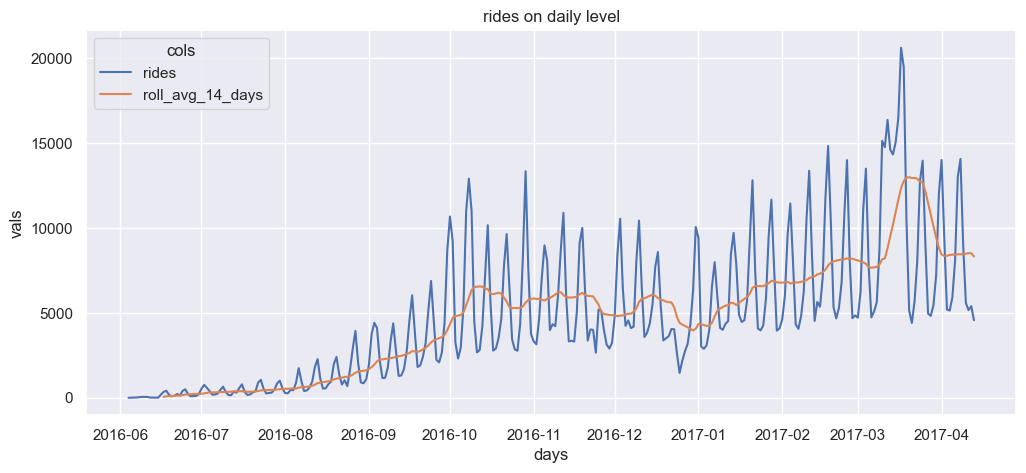

In [5]:
df_daily_rides = plot_values_on_daily_level(df = df_hourly_rides,
                                            value_column = 'rides', 
                                            time_column = "created_on_hour",
                                            roll_avg_days = 14)

Yes, it appears there is a trend and also seasonality. 
1. First, there is a clear periodicity shown by the amplitudes within intervals of weeks.
2. Second, there is also a clear trend of increasing usage with an interval of almost one year.The moving average line is showing this trend clearly.

### Task #2

Plot a ride distance histogram.
What is the distribution? is it normal?

### Task #2 - Answer

Given that the data is quite large, let's take several samples for the histogram and visually check if the distribution significantly changes between samples. 
Afterwards, let's run the Kolmogorov-Smirnov test to test the null hypothesis that the data is not normally distributed.

In [6]:
from utils import sample_and_plot_histogram

In [7]:
# sample_and_plot_histogram(df = df_rides, 
#                           per_of_sample  = 0.01,
#                           value_columns = "distance_travelled",
#                           number_of_samples = 20)

None of the different samples appear to be normal. The main reason is that they do not exhibit properties of a normal distribution, the most obvious being the lack of symmetry. 
Let's test the hypothesis that the data comes from a normal distribution using the Kolmogorov-Smirnov test.

In [8]:
scipy.stats.kstest(df_rides.distance_travelled.dropna(how='all'),
                   scipy.stats.norm.cdf)

KstestResult(statistic=0.9999020691530339, pvalue=0.0, statistic_location=4.0, statistic_sign=-1)

$P_{value} = 0$ indicating that we must reject the null hypothesis that the distance traveled follows a normal distribution.

## Preprocessing

In [9]:
df_times = pd.read_csv('times.csv')
df_times['datetime'] = pd.to_datetime(df_times['datetime'])
df_times.head()

,datetime,weekday,month,day,year,weekofyear,dayofyear,us_holiday,us_holiday_type,hour
0,2016-06-04 00:00:00,5,6,4,2016,22,156,False,None,0
1,2016-06-04 01:00:00,5,6,4,2016,22,156,False,None,1
2,2016-06-04 02:00:00,5,6,4,2016,22,156,False,None,2
3,2016-06-04 03:00:00,5,6,4,2016,22,156,False,None,3
4,2016-06-04 04:00:00,5,6,4,2016,22,156,False,None,4


### Task #3

You have time features in the df_times dataframe. 
Merge this dataframe with the hourly rides dataframe, so you can use those features later.

### Task #3 - Answer

In order to prevent from issues when joining the data lets run several queries 



In [10]:
from utils import queries_before_join

In [11]:
queries_before_join(df_times = df_times, 
                    df_hourly_rides = df_hourly_rides)

Number of unique time points in df_times: 7531

Number of unique time points in df_hourly_rides : 7296

Duplicates in `df_times`: 0

ow many out of df_hourly_rides is in df_times ?  7296

Out of the df_times observations, what is the distribution of the times that do not appear in the df_hourly_rides?
 2016-06    202
2016-07     24
2016-08      7
2016-09      1
2017-03      1
Freq: M, Name: datetime, dtype: int64


As it is evident from the above, the df_time object includes all time points present in df_hourly_rides and more. Furthermore, the time points that exist in df_time but not in df_hourly_rides are spread out across months, but the majority of these measurements are related to the beginning of the data. Therefore, let's perform a left join on df_hourly_rides and df_time.

In [12]:
df_hourly_times_rides = pd.merge(df_times, 
                                 df_hourly_rides, 
                                 left_on='datetime', 
                                 right_on='created_on_hour',
                                 how="left")

# Test unchanged df_hourly_rides shape
df_hourly_times_rides.shape

(7531, 12)

### Task #4

We would like to add a lag feature, which retrieves the amount of rides taken at the same exact hour last week. 
Please implement this feature.
What is the correlation between current and last week's rides?

### Task #4 - Answer

In [13]:
from utils import add_time_unit_lag

In [14]:
df_hourly_times_rides = add_time_unit_lag(df = df_hourly_times_rides, 
                                          time_unit ='d', 
                                          lag = 7)

In [15]:
df_hourly_times_rides[["datetime","rides","rides_last_d_7"]].tail(10)

,datetime,rides,rides_last_d_7
7521,2017-04-13 09:00:00,282.0,357.0
7522,2017-04-13 10:00:00,288.0,304.0
7523,2017-04-13 11:00:00,277.0,265.0
7524,2017-04-13 12:00:00,259.0,288.0
7525,2017-04-13 13:00:00,295.0,294.0
7526,2017-04-13 14:00:00,310.0,318.0
7527,2017-04-13 15:00:00,350.0,352.0
7528,2017-04-13 16:00:00,401.0,388.0
7529,2017-04-13 17:00:00,441.0,477.0
7530,2017-04-13 18:00:00,417.0,614.0


#### Calculating correlation 

In [16]:
df_hourly_times_rides[["rides","rides_last_d_7"]].corr().iloc[0:1,1:2]

,rides_last_d_7
rides,0.832631


Correlatiom its pretty hight $0.83$ meaning that same hour last week can be used as valuable feature for our final model.
Bur before jumping into conclusions, let's test the correlations between the target variables and another back legs

In [17]:
for time, lag in [('d',14),('d',3),('h',12),('h',5),('h',32)]:
    df_i = add_time_unit_lag(df = df_hourly_times_rides, 
                                          time_unit =time, 
                                          lag = lag)
    print(df_i[["rides",f"rides_last_{time}_{lag}"]].corr().iloc[0:1,1:2],'\n')
    

       rides_last_d_14
rides         0.799237 

       rides_last_d_3
rides        0.296375 

       rides_last_h_12
rides         0.274643 

       rides_last_h_5
rides        0.547048 

       rides_last_h_32
rides          0.25062 



It appears that there is a significant correlation (0.79) with a lag of two weeks, while other random lags have lower correlation. This indicates that the results make sense.

## Model

### Task #5

We would like to predict how many rides will occur every hour.

As a first step, propose a simple baseline and measure its MAE (mean absolute error)

### Task #5 - Answer

Let's create two naive baselines.

1. One in which we are not allowed to use any data outside of the test set at all. 
    1. A good use case for this would be a business that makes predictions a month in advance. 
    2. The assumption in this case is that the business **cannot respond** quickly to predictions on short intervals. 


2. In the second baseline, we are allowed to use all data up until N hour before. 
    1. This would be useful for a dynamic business that quickly adjusts to changes in the environment. 
    2. The assumption in this case is that the business **can respond** quickly to predictions on short intervals.

In [18]:
df = df_hourly_times_rides[:]

### First basline 
In this baseline, we are not allowed to use any data after 2017-03-30 and we are also ignoring all other features except for historical rides per day of the week and hour. So, we are going to use the average rides per hour and day of the week for the 4 weeks prior. Of course, it is possible to create more 'smart' baselines, such as Search for bttter interval back, assigning higher weights for closer dates or even taking trends into account.

#### Train test split 

In [30]:
days_back_range = 28
test = df[(df.datetime >= '2017-03-30 00:00:00') & (df.datetime < '2017-04-13 00:00:00')]
train = df[(df.datetime >= test.datetime.min() - pd.Timedelta(days=days_back_range)) &\
           (df.datetime < test.datetime.min())]

###### Calculating average per dow_hour and assing it for equivalent point over the test set.

In [20]:
from utils import fit_predict_baseline_a

In [21]:
df_actual_vs_pred = fit_predict_baseline_a(df_fit = train, 
                                           df_predict = test, 
                                           groupby_cols = ['weekday', 'hour'], 
                                           value_col = "rides")

##### Calculating MAE

In [22]:
mean_absolute_error(df_actual_vs_pred.actual,
                    df_actual_vs_pred.predicted)

104.53174603174605

###### Plot of predicted vs actual 

In [23]:
from utils import plot_predicted_vs_actual

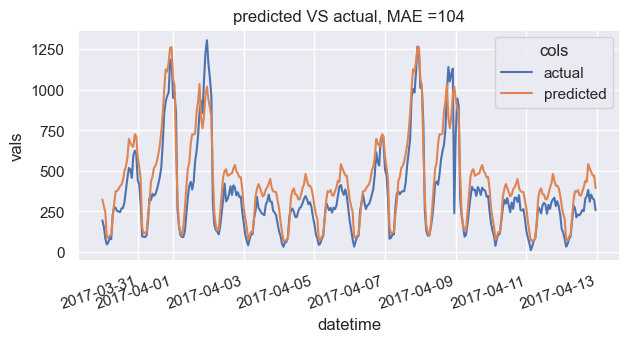

In [24]:
plot_predicted_vs_actual(df = df_actual_vs_pred,
                         fig_size = (7,3))

It appears that in terms of seasonality, baseline_a is catching the weekly and daily patterns. However, it is also clear that it tends to over-predict demands most of the time. The main reason for this is its lack of capturing the overall monthly trend. By taking a simple mean of hours and days of the last month, it completely ignores changes in trends in the new month. 

Another limitation of this baseline is its poor performance in predicting peaks and drops, which may be due to the following reasons: 
1. It completely ignores other features such as day types (holidays, etc.) 
2. It does not use daily/hourly trend features.

Ofcurse we can improve this baseline in terms of MAE by adding more features (As speciel days, trends etc) or simply grid search for better interval of lag history as shown in the following example.

In [25]:
from utils import plot_predicted_vs_actual_for_different_intervals

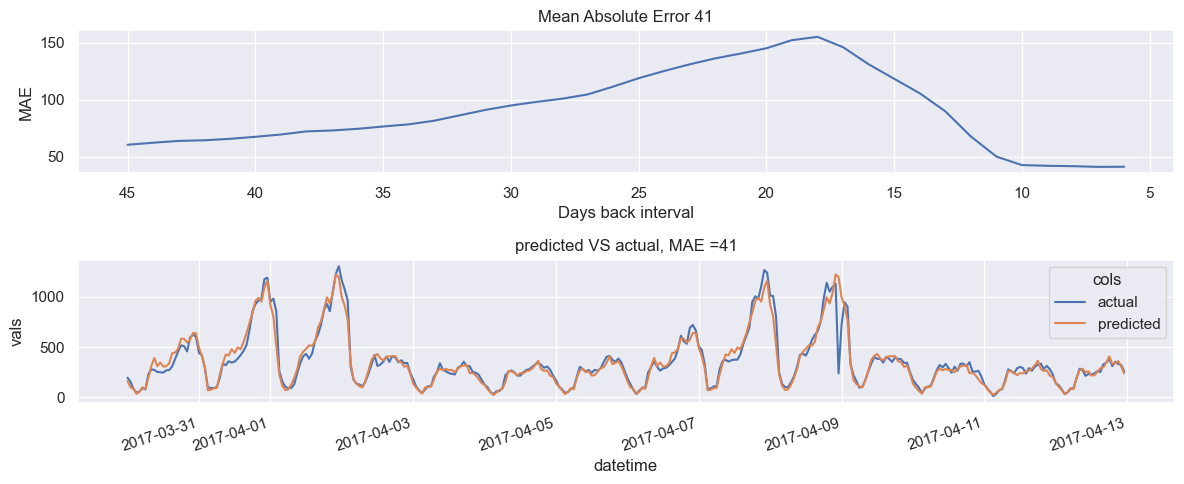

In [34]:
days_back_range = 46

best_mae = plot_predicted_vs_actual_for_different_intervals(df = df, 
                                                            test = test, 
                                                            days_back_range = days_back_range,
                                                            groupby_cols = ['weekday', 'hour'],
                                                            value_col = "rides")

In [26]:
best_mae

NameError: name 'best_mae' is not defined

In [26]:
# sns.lineplot(
#     data=df_actual_vs_pred,
#     x="datetime", y="erros"
# );

### Seconde baseline 

For the following baseline, in orther to generate predicrion for point $n$ we will average all previous $n-1$ to $n-k$ points. 

The assumptions for this are: 
1. there are k last points for all test points (no missing values or NaNs) 
2. Using all data up until the last hour is aligned with business logic, meaning that this short-term prediction is valuable for the business as it is able to act accordingly to this short-term. 

Here we will also be not use addtional features.

In [28]:
from utils import fit_predict_baseline_b

In [31]:
mae,df_actual_vs_pred = fit_predict_baseline_b(df = df, 
                                               df_predict = test, 
                                               k_last_hours = 10, 
                                               value_col = "rides")

mae

185.4738095238095

As same as before in order to take a closer look and to examine how we can improve th baseline we can gridsearch for different intervals 

In [47]:
def plot_predicted_vs_actual_for_different_intervals_bl_b(df,
                                                         test,
                                                         hours_back_range,
                                                         value_col,
                                                         fig_size = (9,6)):
    mae_list = []
    sns.set(rc={'figure.figsize':fig_size})
    
    mae_list = [np.nan] * hours_back_range
    best_mae = 1000
    best_mae_interval = hours_back_range
    
    for i in range(hours_back_range,0,-1):

        mae, df_actual_vs_pred = fit_predict_baseline_b(df = df, 
                                                        df_predict = test, 
                                                        k_last_hours = i, 
                                                        value_col = value_col)
        mae_list[i - 1] = mae
        df_melt = df_actual_vs_pred[[f"predicted","actual"]].reset_index().melt('datetime', 
                                                                                var_name='cols',  
                                                                                value_name='vals')

        fig, ax =plt.subplots(2,1)

        sns.lineplot(
            data=df_melt,
            x="datetime", y="vals", hue="cols", ax=ax[0]
        ).set(title=f"predicted VS actual last {i} hours, MAE ={int(mae)}")
        
        ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=15, ha="right")

        ax[1].plot(mae_list)
        
        ax[1].set_title("Mean Absolute Error")
        plt.xlim(-1,hours_back_range)
        plt.ylim(-1,250)
        plt.tight_layout()
        ax[1].invert_xaxis()
        plt.show()

        clear_output(wait=True)

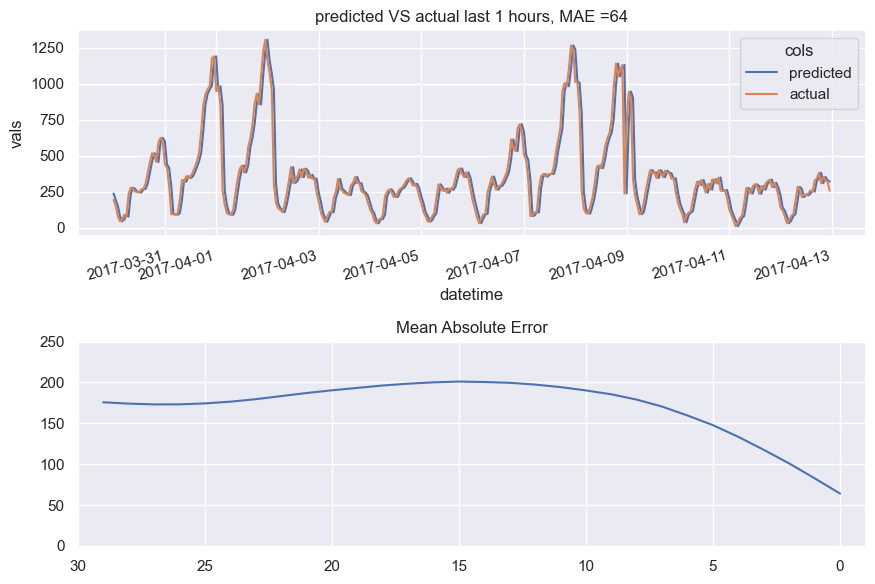

In [48]:
hours_back_range = 30
plot_predicted_vs_actual_for_different_intervals_bl_b(df = df,
                                                      test = test,
                                                      hours_back_range = hours_back_range,
                                                      value_col = "rides")

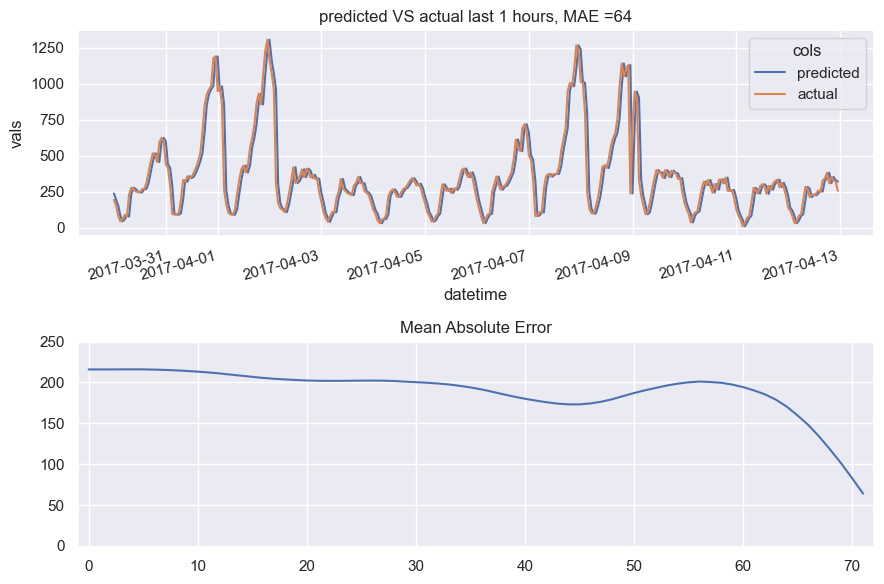

In [29]:
mae_list = []
sns.set(rc={'figure.figsize':(9,6)})

max_hours = 72
for i in range(max_hours,0,-1):
    n_last_hours = i 
    train = df[(df.datetime >= test.index.min() - pd.Timedelta(hours=n_last_hours))].set_index("datetime")
    test[f"predicted"] = train[["rides"]].rolling(f'{n_last_hours}h').mean().shift(periods=1)
    test_i =  test.rename(columns = {"rides":"actual"})
    
    mae = mean_absolute_error(test_i.actual,
                              test_i.predicted)
    mae_list.append(mae)
    df_melt = test_i[[f"predicted","actual"]].reset_index().melt('datetime', var_name='cols',  value_name='vals')
    
    fig, ax =plt.subplots(2,1)

    sns.lineplot(
        data=df_melt,
        x="datetime", y="vals", hue="cols", ax=ax[0]
    ).set(title=f"predicted VS actual last {n_last_hours} hours, MAE ={int(mae)}")
    ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=15, ha="right")
    
    ax[1].plot(mae_list)
    ax[1].set_title("Mean Absolute Error")
    plt.xlim(-1,max_hours)
    plt.ylim(-1,250)
    plt.tight_layout()

    plt.show()

    clear_output(wait=True)

As it clearly shown, for the given baseline technique, using the last hour value as predictor for the next hour error is minimal. 
But in many cases we are willing to generate predictions earlier, cause in reality there is many contraits that not allows to use so short time prediction.
For example, To move taxis between areas, like cities, in the morning of israel its impossible thing.

in case of missing values we need to think and recommand for techniques for imputing

### Task #6

Now let's create a model and calculate its performance.

Is it better than the baseline?

**Use the same test set from previous task**.

Lets target this section by two ways : 
1. A mechine learning approach
2. Complex time series aprroch 

In [339]:
df = df_hourly_times_rides[:]

## Mechine learning approch

#### Lets create some features 

In [340]:
df = df.reset_index()
# last day rides 
hourly_times_rides_last_day = pd.concat([ df[['datetime']] + pd.Timedelta(days=1),
                                          df[['rides']] ], 
                                          axis = 1
                                        )
hourly_times_rides_last_day.rename(columns  = {"rides":"rides_last_day",
                                                "datetime":"datetime_last_day"}, inplace = True)

df = pd.merge(df, 
              hourly_times_rides_last_day, 
              left_on='datetime', 
              right_on='datetime_last_day',
              how="left")


In [341]:
# last day rides 
hourly_times_rides_last_5_h = pd.concat([ df[['datetime']] + pd.Timedelta(hours=5),
                                          df[['rides']] ], 
                                          axis = 1
                                        )
hourly_times_rides_last_5_h.rename(columns  = {"rides":"rides_5_h",
                                               "datetime":"datetime_last_5_h"}, inplace = True)

df = pd.merge(df, 
              hourly_times_rides_last_5_h, 
              left_on='datetime', 
              right_on='datetime_last_5_h',
              how="left")


In [364]:
df = df[~df.rides.isna()]

### Train test split 

In [376]:
test = df[(df.datetime >= '2017-03-30 00:00:00') & (df.datetime < '2017-04-13 00:00:00')]
train = df[(df.datetime >= test.datetime.min() - pd.Timedelta(days=300)) &\
           (df.datetime < test.datetime.min())]

y = 'rides'
X = ['weekday', 'month', 'day', 'year', 'weekofyear',
     'dayofyear', 'us_holiday', 'us_holiday_type', 
     'hour','rides','rides_last_week']

X_train = train[X]
y_train = train[y]
X_test = test[X]
y_test = test[y]

In [366]:
X_train.columns

Index(['weekday', 'month', 'day', 'year', 'weekofyear', 'dayofyear',
       'us_holiday', 'us_holiday_type', 'hour', 'rides', 'rides_last_week'],
      dtype='object')

### Fit model

In [377]:
import xgboost
from numpy import absolute

model = xgboost.XGBRegressor(verbosity=0)  
x_train = X_train.drop(columns = ['us_holiday_type'] +[i for i in X_train.columns if "datetime"  in i])
model.fit( x_train, y_train)

y_train_pred = model.predict(x_train)

In [378]:
mean_absolute_error(y_train_pred, y_train)

0.37098764184743765

In [379]:
x_test = X_test.drop(columns = ['us_holiday_type'] +[i for i in X_train.columns if "datetime"  in i])
y_test_pred = model.predict(x_test)

In [380]:
mean_absolute_error(y_test_pred, y_test)

1.1752374143827529

# Seconde approche - Time series approch

In [389]:
from neuralprophet import NeuralProphet

### Task #7

You've been offered to purchase an extension of this historical dataset going further into the past. In order to decide whether it is worthwhile, you need to estimate if there's a potential to improve the model given this data.

What is your estimation and why?

#### Answer 
A good approch to deside if addtional data can contribute to our performance is to take a look on the trend of performance with respect to to past interval.
So lets returning the above with several interval and present the results 

In [409]:
train = df[df.datetime < test.datetime.min() ]


(6941, 19)

In [420]:
from tqdm import tqdm


In [423]:
mae_history = []
for back_interval in tqdm(range(10,train.shape[0],20)):

    train_i = train[(train.datetime >= test.datetime.min() - pd.Timedelta(days=back_interval)) &\
                    (train.datetime < test.datetime.min())]



    X_train = train_i[X]
    y_train = train_i[y]
    X_test = test[X]
    y_test = test[y]


    model = xgboost.XGBRegressor(verbosity=0) 

    x_train = X_train.drop(columns = ['us_holiday_type'] +[i for i in X_train.columns if "datetime"  in i])
    model.fit( x_train, y_train)

    y_train_pred = model.predict(x_train)

    x_test = X_test.drop(columns = ['us_holiday_type'] +[i for i in X_train.columns if "datetime"  in i])

    y_test_pred = model.predict(x_test)

    mae = mean_absolute_error(y_test_pred, y_test)

    mae_history.append(mae)


 20%|███████████▍                                             | 70/347 [00:33<02:13,  2.07it/s]


KeyboardInterrupt: 

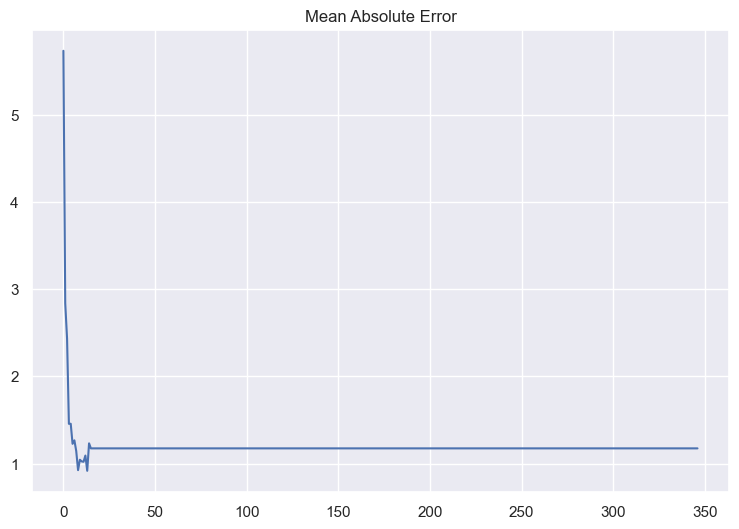

In [422]:
fig, ax =plt.subplots(1,1)
ax.plot(mae_history)
ax.set_title("Mean Absolute Error")
plt.show()

As it easy to see after lag back of arounf 30-20 days, there is no sagnificant impact of extension the data back in terms of test performance.